# 0.0 Business Problem

Como um Consultor de Ciência de Dados para criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

Entregaveis da consultoria:

- Modelo em produção com API.
- Relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu.

  No seu relatório deve conter as respostas para as seguintes perguntas:

 -   Qual a Precisão e Acurácia do modelo?
 -   Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
 -   Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
 -   Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
 -   Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

Data source: [Link](https://www.kaggle.com/ntnu-testimon/paysim1)

# 0.1 Imports and Helper Functions

In [1]:
# Importings
import pandas as pd
import numpy as np
import time

# Importings Dask test
import dask.array as da
import dask.dataframe as dd


# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# General Librarys
from MyToolBox import MyToolBox as mtb
from IPython.display import Image
from IPython.core.display import HTML


from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# Helper Functions  trans_fraud_data.csv

def get_data(path, target, kind='train'):
    if kind == 'train':
        train = pd.read_csv(path)
        X = train.drop(target, axis=1)
        y = train[target]
    else:
        test = pd.read_csv(path)
        X = test.copy()

    return train, X, y


def get_data_dask(path, target, kind='train'):
    if kind == 'train':
        train = dd.read_csv(path)
        X = train.drop(target, axis=1)
        y = train[target]
    else:
        test = dd.read_csv(path)
        X = test.copy()

    return train, X, y

def balanced_target(target, dataset, hue=None):
    """
    Function to check the balancing of the target variable.

    :target:  An pd.Series of the target variable that will be checked.
    :dataset: An Dataframe object. 
    """
    sns.set(style='darkgrid', palette='Accent')
    ax = sns.countplot(x=target, hue=hue, data=dataset)
    ax.figure.set_size_inches(10, 6)
    ax.set_title('Feature Distribution', fontsize=18, loc='center')
    ax.set_xlabel(target, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax=ax

def hipo_test(*samples):

    samples = samples

    try:
        if len(samples) == 2:
            stat, p = ttest_ind(*samples)
        elif len(samples) > 2:
            stat, p = f_oneway(*samples)
    except:
        raise Exception("Deve ser fornecido pelo menos duas samples!!!")

    if p < 0.05:
        print(f'O valor de p é: {p}')
        print('Provável haver diferença')
    else:
        print(f'O valor de p é: {p}')
        print('Provável que não haja diferença')

    return stat, p

def Myheat_map(dataset, variaveis):

    df_corr = dataset[variaveis].corr()

    fig, ax = plt.subplots(figsize=(16, 10))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
                   linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
                   cbar_kws={"shrink": .8}, square=True)# ticks
    yticks = [i.upper() for i in corr.index]
    xticks = [i.upper() for i in corr.columns]
    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks)

    # title
    title = 'CORRELATION MATRIX\n'
    plt.title(title, loc='left', fontsize=18)
    plt.show()

# 1.0 Collect Data

In [29]:
# With pandas
start = time.time()

train_pd, X_pd, y_pd = get_data(path='../data/trans_fraud_data.csv', target='isFraud')
print(f'Quantidade de Colunas {train.shape[1]}')
print(f'Quantidade de Observações {train.shape[0]}')
train.head()

print(f'\nTempo de execução: {round(time.time()-start,2)} segundos')

Quantidade de Colunas 11
Quantidade de Observações 6362620

Tempo de execução: 8.31 segundos


## 1.1 With Dask

In [11]:
# Iniciando um cluster local
from dask import delayed
from dask.distributed import LocalCluster, Client


#cluster = LocalCluster()
client = Client(cluster)

In [16]:
# With dask
start = time.time()

train, X, y = get_data_dask(path='../data/trans_fraud_data.csv', target='isFraud')
print(f'Quantidade de Colunas {train.shape[1]}')

obs = delayed(len)(delayed(list)(train.index))
print(f'Quantidade de Observações {obs.compute()}')
train.head()

print(f'\nTempo de execução: {round(time.time()-start,2)} segundos')

Quantidade de Colunas 11
Quantidade de Observações 6362620

Tempo de execução: 4.59 segundos


In [26]:
start = time.time()
train['amount'] = train['amount'] *2
print(f'\nTempo de execução: {round(time.time()-start,2)} segundos')


Tempo de execução: 0.01 segundos


# 2.0 Data Description

- Não possuimos missing values.
- Bastante desbalanciado.
- isFlaggedFraud possui somente 16 observações,as quais também estão como positivas em isFraud, podemos nos desfazer dessa variável.
- Criar a variável type_dest e excluir nameOrig e nameDest.

In [ ]:
pd.DataFrame({'missingPerc': train_pd.isna().mean(),
              'uniques': train_pd.nunique(),
              '%uniquePerc': (train_pd.nunique()/train.shape[0])*100,
              'data_types': train_pd.dtypes,
              'skew': train_pd.skew(),
              'kurtosis': train_pd.kurt()
              })

## 2.1 isFraud vs isFlaggedFraud

Quantidade de eventos positivos - isFraud- 8213
Percentual de eventos positivos - isFraud- 0.12908204481801522

Quantidade de eventos positivos - isFlaggedFraud- 16
Percentual de eventos positivos - isFlaggedFraud- 0.12908204481801522



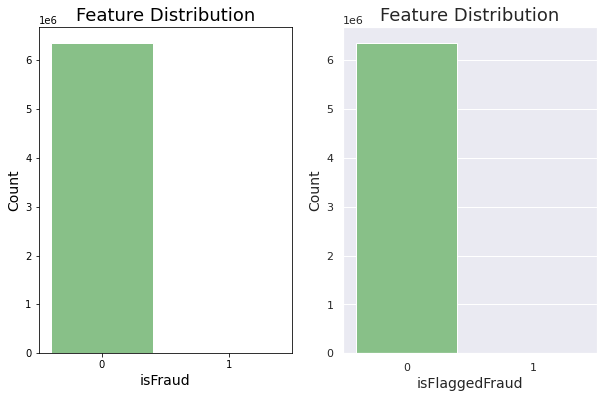

In [14]:
quant = train['isFraud'].sum()
perc = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFraud- {quant}')
print(f'Percentual de eventos positivos - isFraud- {perc}\n')

quant1 = train['isFlaggedFraud'].sum()
perc1 = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFlaggedFraud- {quant1}')
print(f'Percentual de eventos positivos - isFlaggedFraud- {perc1}\n')


# Plots
plt.subplot(1,2, 1)
balanced_target('isFraud', dataset=train)

plt.subplot(1,2, 2)
balanced_target('isFlaggedFraud', dataset=train)

# 2.2 isFlaggedFraud

In [15]:
dadosTemp = train.loc[train['isFlaggedFraud']==1,]
dadosTemp

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


# 2.3 Amount

In [16]:
train.loc[train['isFraud'] == 1,'amount'].describe().T

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

# 2.3 Outras variáveis 
- Operações com destino tipo 'Merchant' tanto old quanto newbalance é igual a 0.

In [17]:
# Describe
variables = ['step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
train[variables].describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.0,239.000,3.350000e+02,7.430000e+02
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.0,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.0,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.0,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.0,214661.440,1.111909e+06,3.561793e+08


In [18]:
# Percentual de operações amount != de zero oldBalanceDest e newBalanceDest são iguais a 0
quant_dest = train.loc[(train['amount'] != 0) & (train['oldbalanceDest'] == 0) & (train['newbalanceDest'] == 0), ]

perc_quant_dest = round(quant_dest.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_dest}%')

O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais 36.0%


In [19]:
quant_dest.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0


In [20]:
# Percentual de operações amount != de zero oldBalanceOrig e newBalanceOrig são iguais a 0

quant_orig = train.loc[(train['amount'] != 0) & (train['oldbalanceOrg'] == 0) & (train['newbalanceOrig'] == 0), ]

perc_quant_orig = round(quant_orig.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_orig}%')

O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais 33.0%


In [21]:
quant_orig.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
29,1,PAYMENT,9920.52,C764826684,0.0,0.0,M1940055334,0.0,0.0,0,0
30,1,PAYMENT,3448.92,C2103763750,0.0,0.0,M335107734,0.0,0.0,0,0
31,1,PAYMENT,4206.84,C215078753,0.0,0.0,M1757317128,0.0,0.0,0,0
32,1,PAYMENT,5885.56,C840514538,0.0,0.0,M1804441305,0.0,0.0,0,0
33,1,PAYMENT,5307.88,C1768242710,0.0,0.0,M1971783162,0.0,0.0,0,0


# 3.0 Mapa de Hipoteses

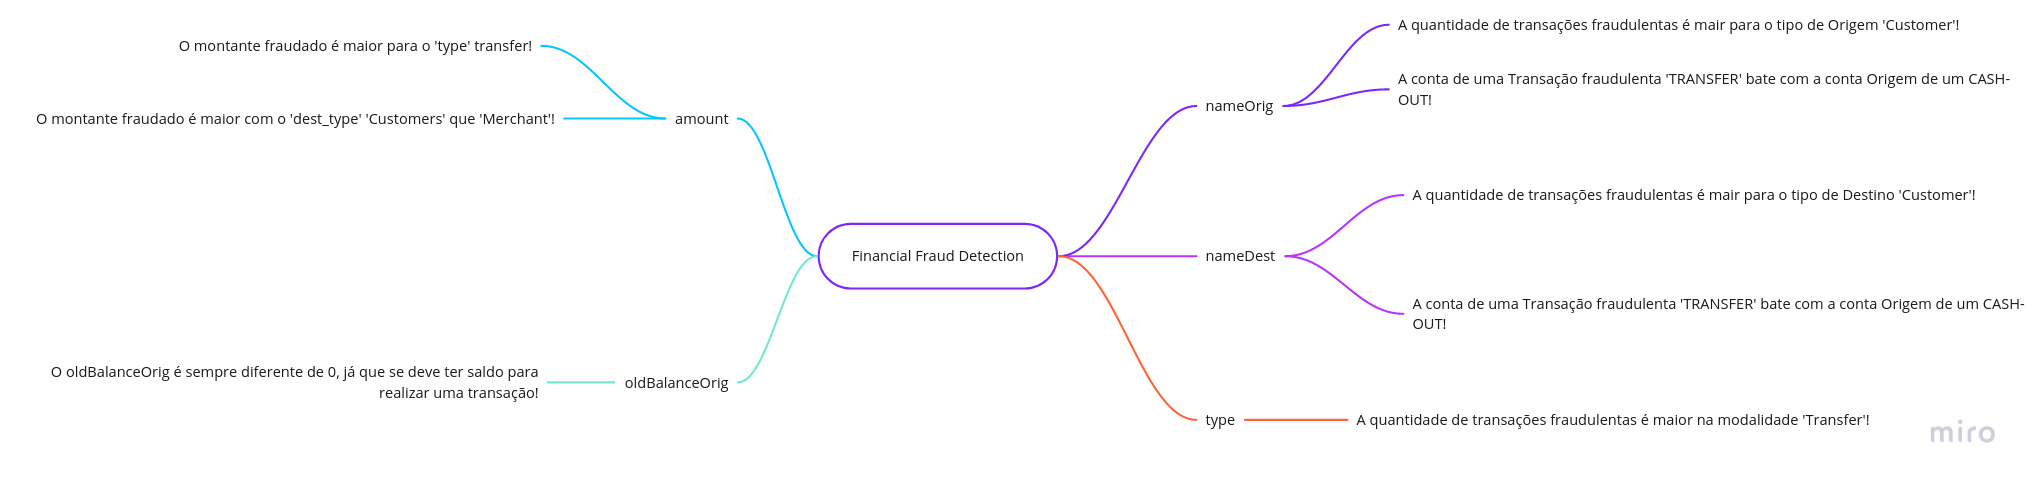

In [22]:
Image("../img/map_mental.jpg")

# 4.0 Feature Engineering

In [23]:
# copy
treino = train.copy()

X = treino.drop('isFraud', axis=1)
y = treino['isFraud']

# dest_type
treino['dest_type'] = treino['nameDest'].apply(lambda x: 1 if x[0] == 'M' else 0)  # 1 - Merchant e 0-Customer

# error_transaction
treino['error_transaction'] = treino['amount'] - (treino['oldbalanceOrg'] - treino['newbalanceOrig'])

# amount/step
treino['amount_step'] = treino['amount']/treino['step']

#Encoding type
enc = OrdinalEncoder()
treino['type'] = enc.fit_transform(np.array(treino['type']).reshape(-1, 1))

# Dropping 'isFlaggedFraud'
treino.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], inplace=True, axis=1)

# 5.0 EDA

# 5.1 Análise Univariada

## 5.1.1 Variáveis numericas

- Alto Skew
- Grande quantidade de outliers

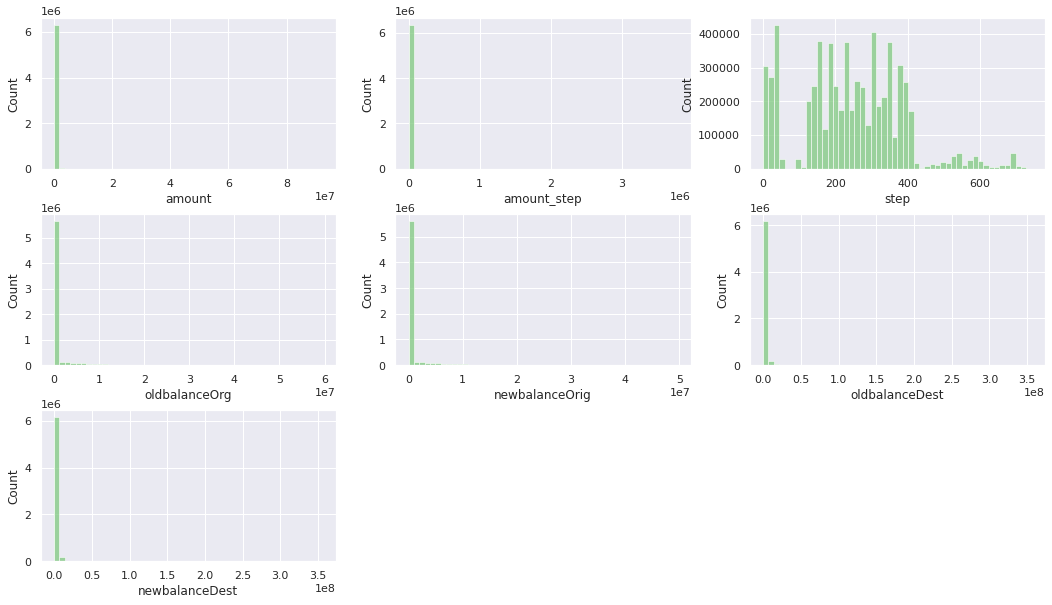

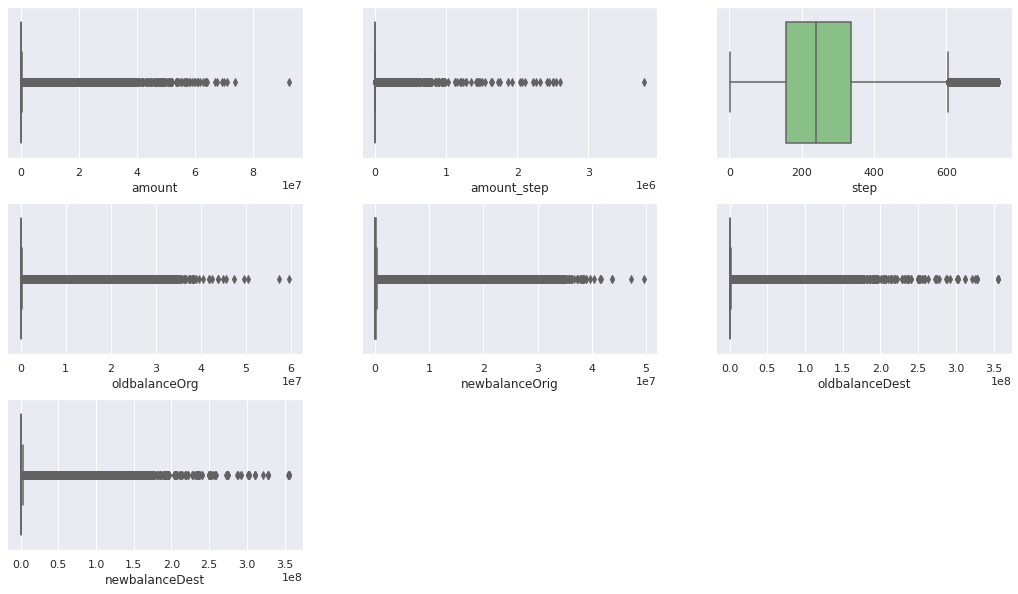

In [24]:
explorer = mtb.EDA(treino)
explorer.multi_histograms(['amount','amount_step', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])
explorer.multi_boxplots(['amount','amount_step', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

## 5.1.2 Retirando Outliers

In [ ]:
# Eliminando os Outliers
lof = LocalOutlierFactor(n_jobs=-1)
yhat = lof.fit_predict(treino)
mask = yhat != -1

new_treino = treino[mask:]

# 5.2 Análise Multivariada

## 5.2.1 Númericas

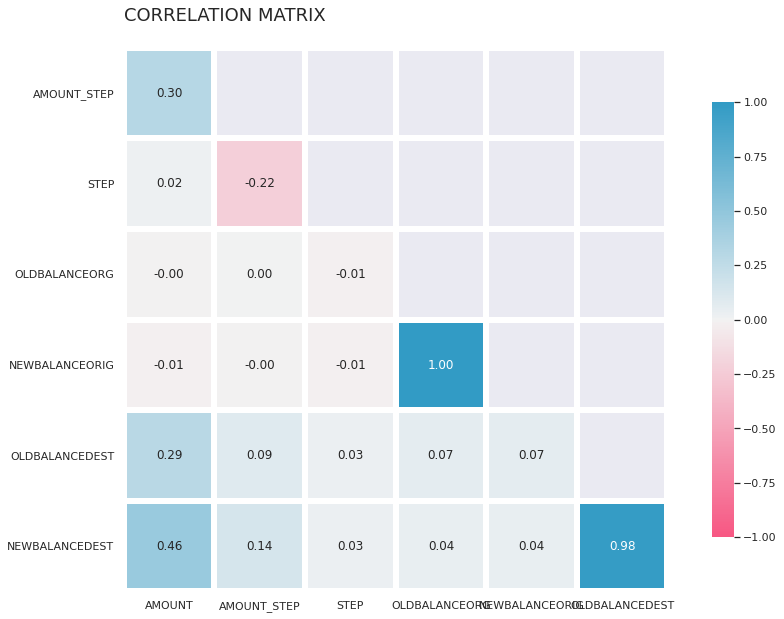

In [64]:
# Matriz Corr

variaveis = ['amount','amount_step', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
Myheat_map(dataset=treino, variaveis=variaveis)

## 5.2.2 Categóricas

Text(0.5, 1.0, 'Pointbiserialr')

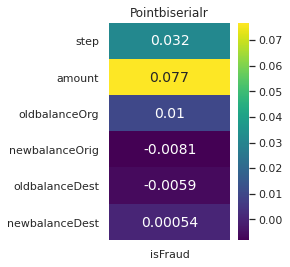

In [23]:
from scipy.stats import pointbiserialr

# Variáveis numericas
num_vars =  ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Correlações
corrs = [pointbiserialr(treino['isFraud'], treino[var])[0] for var in num_vars]
df_corr = pd.DataFrame({'isFraud': corrs}, index=num_vars)

# Plot Matrix
fig, ax = plt.subplots()
plt.subplot(1, 2, 1)
sns.heatmap(df_corr, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Pointbiserialr")

## 5.2.3 KbinsDicretizer Amount

<ipython-input-56-711ae3ba1920>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj_temp['bins'] = data_trans


<AxesSubplot:xlabel='bins'>

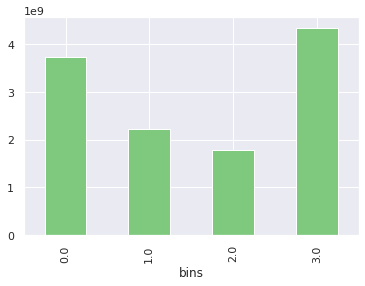

In [56]:
from sklearn.preprocessing import KBinsDiscretizer
obj_temp = treino.loc[treino['isFraud']==1,]


kbins = KBinsDiscretizer(n_bins=4, encode= 'ordinal' , strategy= 'uniform' )
data_trans = kbins.fit_transform(np.array(obj_temp['amount']).reshape(-1,1))

# Plot
obj_temp['bins'] = data_trans
obj_temp.groupby('bins').sum()['amount'].plot(kind='bar')

### 5.2.3.1 checando os limites

In [58]:
# bin 0
bin_0_min = obj_temp.loc[obj_temp['bins']==0,'amount'].min()
bin_0_max = obj_temp.loc[obj_temp['bins']==0,'amount'].max()

#bin 3
bin_3_min = obj_temp.loc[obj_temp['bins']==3,'amount'].min()
bin_3_max = obj_temp.loc[obj_temp['bins']==3,'amount'].max()

# Report
print(f'Para o bin 0 limite minimo {bin_0_min} e o limite maximo {bin_0_max}')
print(f'Para o bin 3 limite minimo {bin_3_min} e o limite maximo {bin_3_max}')

Para o bin 0 limite minimo 0.0 e o limite maximo 2498837.82
Para o bin 3 limite minimo 7513581.46 e o limite maximo 10000000.0


# 5.3 Hipóteses

Lista de Hipóteses!

1. O montante fraudado é maior para o 'type' transfer!
2. O percentual de error_transaction é maior que 50%!
3. O montante fraudado é maior com o 'dest_type' Customers que Merchant!
4. O oldbalanceOrig é sempre diferente de 0, já que se deve ter saldo para realizar uma transação!
5. A quantidade de transações fraudulentas é maior para o tipo de Origem 'Customer'!
6. A conta de uma transação fraudulenta 'TRANSFER' bate com a conta Origem de um CASH-OUT!
7. A quantidade de transações fraudulentas é maior na modalidade 'TRANSFER'!

### 5.3.1 H1 O montante fraudado é maior para o 'type' TRANSFER! [TRUE]

In [47]:
#treino['type'] = enc.inverse_transform(np.array(treino['type']).reshape(-1, 1))
dados_temp = treino.loc[treino['isFraud']==1, ]

AMOUNT_TRANSFER = dados_temp.loc[dados_temp['type']=='TRANSFER', 'amount'].sum()
AMOUNT_CASH_OUT = dados_temp.loc[dados_temp['type']=='CASH_OUT', 'amount'].sum()

print(f'\n Quantidade de observações TRANSFER: {AMOUNT_TRANSFER}')
print(f'Quantidade de observações CASH_OUT: {AMOUNT_CASH_OUT}\n')


 Quantidade de observações TRANSFER: 6067213184.01
Quantidade de observações CASH_OUT: 5989202243.83



### 5.3.2 H2 O percentual de error_transaction é maior que 50%!

In [46]:
# Erro
erro_acima_0 = treino.loc[treino['error_transaction'] != 0, ]

#Percentual do erro sobre dataset
perc_error = round(erro_acima_0.shape[0]/train.shape[0]*100, 2)
print(f'O percentual de transações com erro são de {perc_error}')

O percentual de transações com erro são de 93.08


### 5.3.3 H3 O montante fraudado é maior com o 'dest_type' Customers que Merchant![TRUE]

In [21]:
dados_temp1 = treino.loc[treino['isFraud'] == 1, ['amount','dest_type']]

# Montantes
AMOUNT_CUSTOMER = round(dados_temp1.loc[dados_temp1['dest_type']==0, 'amount'].sum(),2) 
AMOUNT_MERCHANT = round(dados_temp1.loc[dados_temp1['dest_type']==1, 'amount'].sum(),2)

# Report
print(f'Quantidade de observações Customers: {AMOUNT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {AMOUNT_MERCHANT}\n')

Quantidade de observações Customers: 12056415427.84
Quantidade de observações Merchant: 0.0



### 5.3.4 H4 O oldbalanceOrig é sempre diferente de 0, já que se deve ter saldo para realizar uma transação![FALSE]

In [25]:
# Percentual de operações amount != de zero oldBalanceOrig e newBalanceOrig são iguais a 0

quant_orig = train.loc[(train['amount'] != 0) & (train['oldbalanceOrg'] == 0) & (train['newbalanceOrig'] == 0), ]

perc_quant_orig = round(quant_orig.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_orig}%')

O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais 33.0%


### 5.3.5 H5 A quantidade de transações fraudulentas é maior para o tipo de Origem 'Customer'![TRUE]

In [41]:
# Montantes
QUANT_CUSTOMER = dados_temp1.loc[dados_temp1['dest_type']==0, 'amount'].shape[0]
QUANT_MERCHANT = dados_temp1.loc[dados_temp1['dest_type']==1, 'amount'].shape[0]

# Report
print(f'Quantidade de observações Customers: {QUANT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {QUANT_MERCHANT}\n')

Quantidade de observações Customers: 8213
Quantidade de observações Merchant: 0



### 5.3.6 H6 A conta de uma transação fraudulenta 'TRANSFER' bate com a conta Origem de um CASH-OUT![FALSE]

In [39]:
CONTA_ORIG = train.loc[(train['isFraud']==1) & (train['type']=='TRANSFER'), 'nameOrig']
CONTA_DEST = train.loc[(train['isFraud']==1) & (train['type']=='CASH_OUT'), 'nameDest']

resultado = set(CONTA_ORIG).intersection(set(CONTA_DEST))
print(f'Contas encontradas:{len(resultado)}')

Contas encontradas:0


### 5.3.6 H7 A quantidade de transações fraudulentas é maior na modalidade 'TRANSFER'!

Quantidade de observações Customers: 4097
Quantidade de observações Merchant: 4116



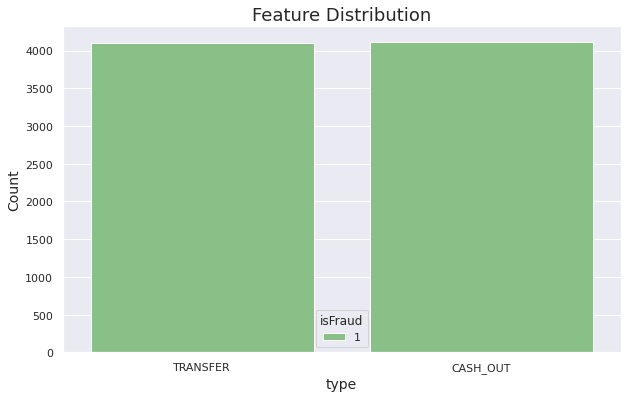

In [48]:
# Montantes
QUANT_TRANSFER = train.loc[(train['isFraud']==1) & (train['type']=='TRANSFER'), 'amount'].shape[0]
QUANT_MERCHANT = train.loc[(train['isFraud']==1) & (train['type']=='CASH_OUT'), 'amount'].shape[0]

# Report
print(f'Quantidade de observações Customers: {QUANT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {QUANT_MERCHANT}\n')

# Quantidade
balanced_target('type', hue='isFraud', dataset=dados_temp)

# 4.0 Feature Engineering - Part02

- Drop os types diferentes 'TRANSFER' e 'CASH_OUT'.
- Criar nova variável com base nos limites encontrados para 'amount'.